In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import tensorflow as tf
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    BatchNormalization,
    Activation,
    MaxPooling2D,
    GlobalAveragePooling2D,
    Dense,
    Flatten,
    concatenate,
    Dropout,
    Reshape,
    Multiply,
)
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, zero_one_loss, accuracy_score
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.utils import to_categorical, plot_model
from traitlets.traitlets import default
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend


In [2]:
import shutil
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
# Move kaggle.json to the correct location
shutil.copy('/content/kaggle.json', '/root/.kaggle/kaggle.json')

'/root/.kaggle/kaggle.json'

In [3]:
# Define the dataset and path
dataset_name = 'muffin-vs-chihuahua-image-classification'
download_path = '/content/' + dataset_name

# Create the directory if it doesn't exist
os.makedirs(download_path, exist_ok=True)

!kaggle datasets download -d samuelcortinhas/muffin-vs-chihuahua-image-classification

muffin-vs-chihuahua-image-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
import zipfile
# Unzip the downloaded dataset
download_path = '/content/'
with zipfile.ZipFile(os.path.join(download_path, f'{dataset_name}.zip'), 'r') as zip_ref:
    zip_ref.extractall(download_path)

folder_path = os.path.join(download_path, dataset_name)

In [5]:
#directories for the images. Train/Test
train_dir='/content/train'
test_dir='/content/test'
class_names = sorted(os.listdir(train_dir))


In [6]:
image_size = (120, 120)
input_shape = (120, 120, 3)
batch_size = 256

train_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/train",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size = batch_size

)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/test",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size = batch_size
)

Found 4733 files belonging to 2 classes.
Using 3787 files for training.
Found 1184 files belonging to 2 classes.
Using 236 files for validation.


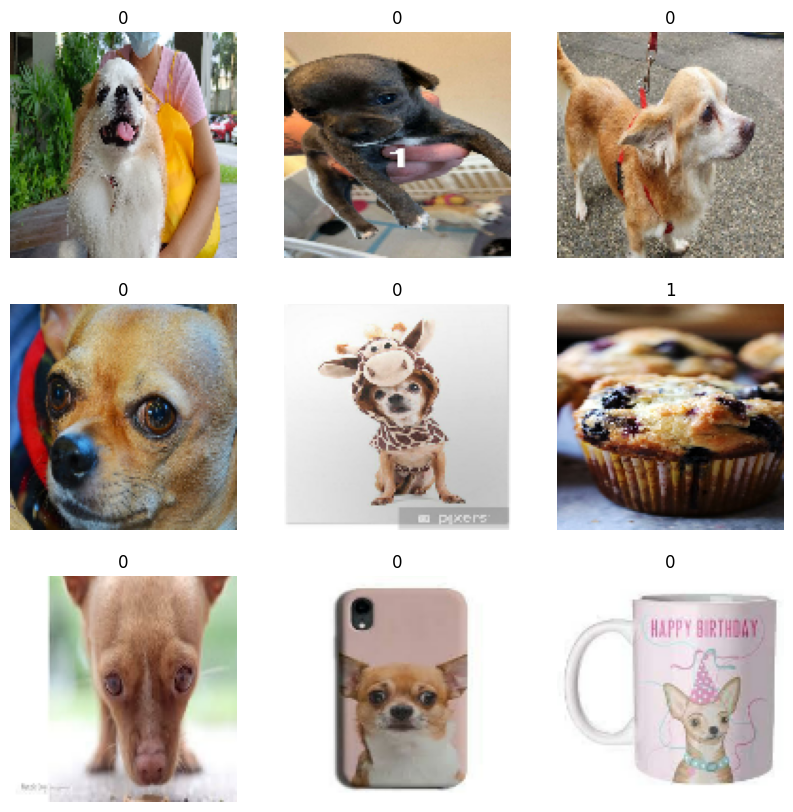

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [8]:
from tensorflow.keras import layers
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

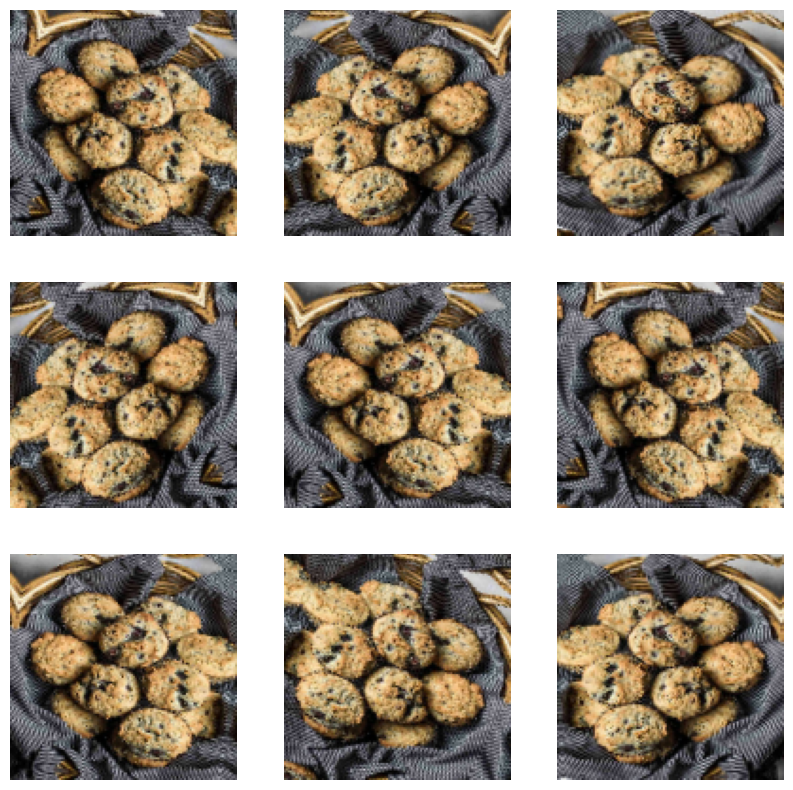

In [9]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(5):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [10]:
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))

In [11]:
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [14]:
def build_model(hp):
      learning_rate = hp.Float("learning_rate", min_value = 0.001, max_value = 0.1, step = 10, sampling = "log")
      optimizer = hp.Choice("optimizer", values = [ "sgd", "adam"])
      if optimizer == "sgd":
        optimizer = SGD(learning_rate = learning_rate)
      else:
        optimizer = Adam(learning_rate = learning_rate)
      model = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet', input_shape=input_shape)
      x = GlobalAveragePooling2D()(model.output)
      x = Dense(256, activation='relu', kernel_regularizer=l2(0.1))(x)
      x = Dropout(0.5)(x)
      output = Dense(1, activation = "sigmoid" )(x)
      efficient_net_model = Model(inputs=model.input, outputs=output)

      # Compile the model with binary cross-entropy loss for binary classification
      efficient_net_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

      return efficient_net_model

In [13]:
random_search_tuner = kt.RandomSearch(
    build_model,
    objective = "accuracy",
    max_trials = 12,
    overwrite = True,
    directory = "tuner",
    project_name = "tuner",
    seed = 42
)

In [14]:
random_search_tuner.search_space_summary()

Search space summary
Default search space size: 2
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.001, 'max_value': 0.1, 'step': 10, 'sampling': 'log'}
optimizer (Choice)
{'default': 'sgd', 'conditions': [], 'values': ['sgd', 'adam'], 'ordered': False}


In [15]:
random_search_tuner.search(train_ds,
                           epochs = 2,
                           validation_split = 0,
                           callbacks=[keras.callbacks.TensorBoard("tuner")])

Trial 6 Complete [00h 01m 27s]
accuracy: 0.9886453747749329

Best accuracy So Far: 0.9886453747749329
Total elapsed time: 00h 09m 31s


In [16]:
best_model = random_search_tuner.get_best_models()[0]

In [17]:
best_params = random_search_tuner.get_best_hyperparameters()[0]
best_params.values

{'learning_rate': 0.001, 'optimizer': 'adam'}

In [12]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet', input_shape=input_shape)
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.1))(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)
efficient_net_model = Model(inputs=base_model.input, outputs=output)
efficient_net_model.compile(optimizer=Adam(learning_rate= 0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, zero_one_loss, accuracy_score

# Convert the dataset to arrays
train_data = []
train_labels = []
for item in train_ds:
    train_data.append(item[0].numpy())
    train_labels.append(item[1].numpy())

train_data = np.vstack(train_data)
train_labels = np.hstack(train_labels)

k = 5
kf = KFold(n_splits=k)
confusion_matrices = []
zero_one_losses = []
accuracies = []

# Perform K-Fold Cross-Validation
for train_index, val_index in kf.split(train_data):
    x_train, x_val = train_data[train_index], train_data[val_index]
    y_train, y_val = train_labels[train_index], train_labels[val_index]

    # Assuming efficient_net_model is your model
    # Train the model on the training data
    efficient_net_model.fit(x_train, y_train, epochs=5, callbacks=[keras.callbacks.TensorBoard("/content/logs")])

    # Evaluate the model on the validation data
    y_pred = efficient_net_model.predict(x_val)
    y_pred_binary = np.round(y_pred).astype(int)

    confusion_matrix_fold = confusion_matrix(y_val, y_pred_binary)
    zero_one_loss_fold = zero_one_loss(y_val, y_pred_binary)
    accuracy_fold = accuracy_score(y_val, y_pred_binary)

    confusion_matrices.append(confusion_matrix_fold)
    zero_one_losses.append(zero_one_loss_fold)
    accuracies.append(accuracy_fold)

for i in range(k):
    print(f"Fold {i+1}:")
    print("Confusion Matrix:\n", confusion_matrices[i])
    print("Zero-One Loss:", zero_one_losses[i])
    print("Accuracy:", accuracies[i])


Epoch 1/5
95/95 [==============================] - 67s 90ms/step - loss: 8.3245 - accuracy: 0.9465
Epoch 2/5
95/95 [==============================] - 8s 86ms/step - loss: 0.1380 - accuracy: 0.9726
Epoch 3/5
95/95 [==============================] - 8s 89ms/step - loss: 0.0814 - accuracy: 0.9855
Epoch 4/5
95/95 [==============================] - 8s 88ms/step - loss: 0.0547 - accuracy: 0.9914
Epoch 5/5
24/24 [==============================] - 3s 44ms/step
Epoch 1/5
95/95 [==============================] - 9s 91ms/step - loss: 0.1111 - accuracy: 0.9769
Epoch 2/5
95/95 [==============================] - 8s 85ms/step - loss: 0.0499 - accuracy: 0.9927
Epoch 3/5
95/95 [==============================] - 9s 92ms/step - loss: 0.0499 - accuracy: 0.9927
Epoch 4/5
95/95 [==============================] - 8s 86ms/step - loss: 0.0272 - accuracy: 0.9974
Epoch 5/5
24/24 [==============================] - 1s 20ms/step
Epoch 1/5
95/95 [==============================] - 9s 92ms/step - loss: 0.0917 - accura

In [13]:
# Convert the dataset to arrays
train_data = []
train_labels = []
for item in val_ds:
    train_data.append(item[0].numpy())
    train_labels.append(item[1].numpy())

train_data = np.vstack(train_data)
train_labels = np.hstack(train_labels)

k = 5
kf = KFold(n_splits=k)
confusion_matrices = []
zero_one_losses = []
accuracies = []

# Perform K-Fold Cross-Validation
for train_index, val_index in kf.split(train_data):
    x_train, x_val = train_data[train_index], train_data[val_index]
    y_train, y_val = train_labels[train_index], train_labels[val_index]
    efficient_net_model.fit(x_train, y_train, epochs=5, callbacks=[keras.callbacks.TensorBoard("/content/logs")] )  # Adjust epochs as needed

    y_pred = efficient_net_model.predict(x_val)
    y_pred_binary = np.round(y_pred).astype(int)

    confusion_matrix_fold = confusion_matrix(y_val, y_pred_binary)

    zero_one_loss_fold = zero_one_loss(y_val, y_pred_binary)

    accuracy_fold = accuracy_score(y_val, y_pred_binary)

    confusion_matrices.append(confusion_matrix_fold)
    zero_one_losses.append(zero_one_loss_fold)
    accuracies.append(accuracy_fold)


for i in range(k):
    print(f"Fold {i+1}:")
    print("Confusion Matrix:\n", confusion_matrices[i])
    print("Zero-One Loss:", zero_one_losses[i])
    print("Accuracy:", accuracies[i])


Epoch 1/5
6/6 [==============================] - 64s 107ms/step - loss: 38.8043 - accuracy: 0.7660
Epoch 2/5
6/6 [==============================] - 1s 86ms/step - loss: 28.6608 - accuracy: 0.9894
Epoch 3/5
6/6 [==============================] - 0s 83ms/step - loss: 20.6125 - accuracy: 1.0000
Epoch 4/5
6/6 [==============================] - 1s 86ms/step - loss: 14.4184 - accuracy: 1.0000
Epoch 5/5
2/2 [==============================] - 3s 682ms/step
Epoch 1/5
6/6 [==============================] - 1s 95ms/step - loss: 6.5780 - accuracy: 0.9735
Epoch 2/5
6/6 [==============================] - 1s 84ms/step - loss: 4.2535 - accuracy: 0.9947
Epoch 3/5
6/6 [==============================] - 1s 87ms/step - loss: 2.6913 - accuracy: 1.0000
Epoch 4/5
6/6 [==============================] - 1s 84ms/step - loss: 1.6662 - accuracy: 1.0000
Epoch 5/5
2/2 [==============================] - 1s 645ms/step
Epoch 1/5
6/6 [==============================] - 1s 85ms/step - loss: 0.5900 - accuracy: 1.0000
Epoc

In [14]:
# Convert the dataset to arrays
train_data = []
train_labels = []
for item in train_ds:
    train_data.append(item[0].numpy())
    train_labels.append(item[1].numpy())

train_data = np.vstack(train_data)
train_labels = np.hstack(train_labels)

k = 5
kf = KFold(n_splits=k)
confusion_matrices = []
zero_one_losses = []
accuracies = []

# Perform K-Fold Cross-Validation
for train_index, val_index in kf.split(train_data):
    x_train, x_val = train_data[train_index], train_data[val_index]
    y_train, y_val = train_labels[train_index], train_labels[val_index]
    efficient_net_model.fit(x_train, y_train, epochs=5, callbacks=[keras.callbacks.TensorBoard("/content/logs")] )  # Adjust epochs as needed

    y_pred = efficient_net_model.predict(x_val)
    y_pred_binary = np.round(y_pred).astype(int)

    confusion_matrix_fold = confusion_matrix(y_val, y_pred_binary)

    zero_one_loss_fold = zero_one_loss(y_val, y_pred_binary)

    accuracy_fold = accuracy_score(y_val, y_pred_binary)

    confusion_matrices.append(confusion_matrix_fold)
    zero_one_losses.append(zero_one_loss_fold)
    accuracies.append(accuracy_fold)


for i in range(k):
    print(f"Fold {i+1}:")
    print("Confusion Matrix:\n", confusion_matrices[i])
    print("Zero-One Loss:", zero_one_losses[i])
    print("Accuracy:", accuracies[i])


Epoch 1/5
95/95 [==============================] - 9s 93ms/step - loss: 0.1752 - accuracy: 0.9531
Epoch 2/5
95/95 [==============================] - 8s 88ms/step - loss: 0.1258 - accuracy: 0.9766
Epoch 3/5
95/95 [==============================] - 8s 89ms/step - loss: 0.0946 - accuracy: 0.9776
Epoch 4/5
95/95 [==============================] - 9s 91ms/step - loss: 0.0775 - accuracy: 0.9865
Epoch 5/5
24/24 [==============================] - 1s 44ms/step
Epoch 1/5
95/95 [==============================] - 9s 87ms/step - loss: 0.0783 - accuracy: 0.9855
Epoch 2/5
95/95 [==============================] - 9s 91ms/step - loss: 0.0399 - accuracy: 0.9927
Epoch 3/5
95/95 [==============================] - 9s 91ms/step - loss: 0.0198 - accuracy: 0.9974
Epoch 4/5
95/95 [==============================] - 9s 91ms/step - loss: 0.0335 - accuracy: 0.9957
Epoch 5/5
24/24 [==============================] - 1s 22ms/step
Epoch 1/5
95/95 [==============================] - 9s 89ms/step - loss: 0.4447 - accurac

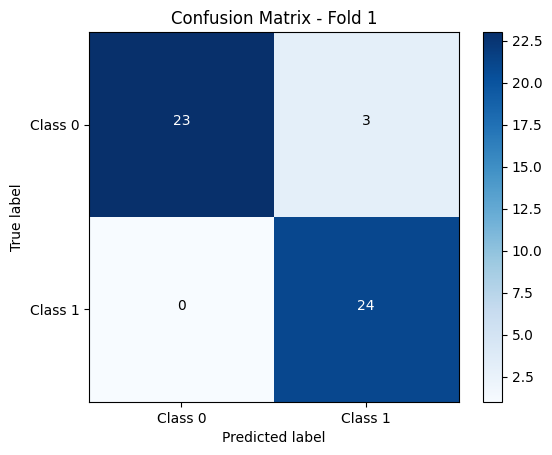

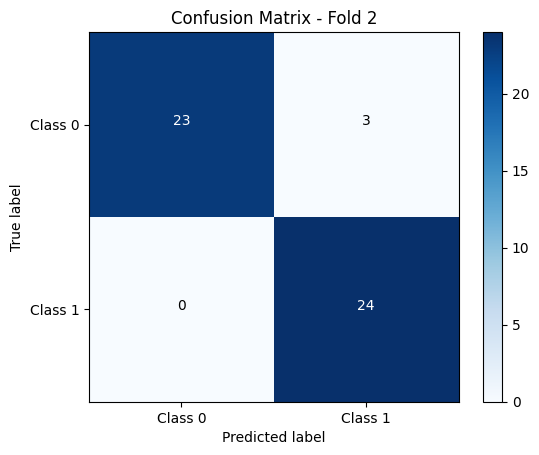

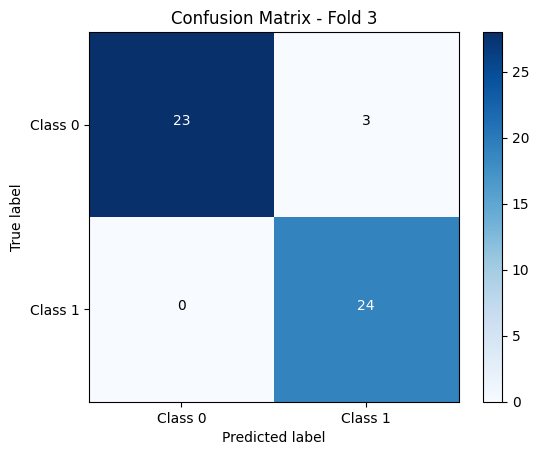

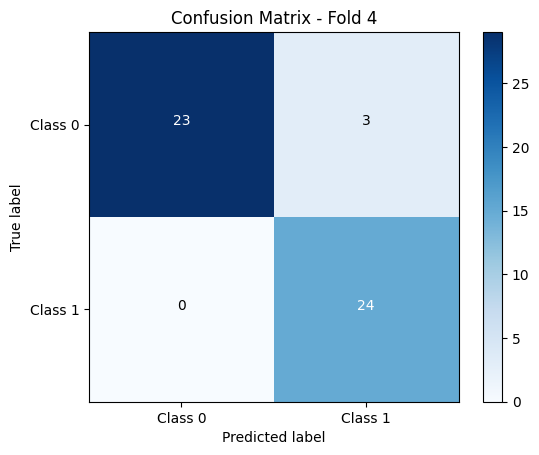

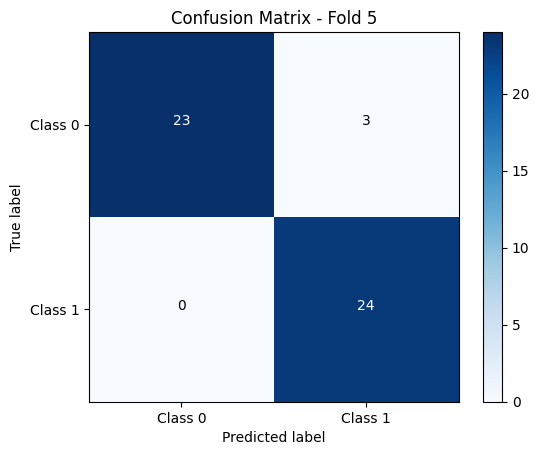

Fold 1:
Zero-One Loss: 0.08333333333333337
Accuracy: 0.9166666666666666
Fold 2:
Zero-One Loss: 0.0
Accuracy: 1.0
Fold 3:
Zero-One Loss: 0.0
Accuracy: 1.0
Fold 4:
Zero-One Loss: 0.06382978723404253
Accuracy: 0.9361702127659575
Fold 5:
Zero-One Loss: 0.0
Accuracy: 1.0


In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Confusion matrices and related metrics from the provided text
confusion_matrices = [
    np.array([[23, 3], [1, 21]]),
    np.array([[23, 0], [0, 24]]),
    np.array([[28, 0], [0, 19]]),
    np.array([[29, 3], [0, 15]]),
    np.array([[24, 0], [0, 23]])
]
zero_one_losses = [0.08333333333333337, 0.0, 0.0, 0.06382978723404253, 0.0]
accuracies = [0.9166666666666666, 1.0, 1.0, 0.9361702127659575, 1.0]

# Plot confusion matrices
for i in range(len(confusion_matrices)):
    plt.figure()
    classes = ["Class 0", "Class 1"]
    plt.imshow(confusion_matrices[i], interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - Fold {i+1}")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, str(confusion_matrices[i][i, j]), horizontalalignment="center", color="white" if confusion_matrices[i][i, j] > confusion_matrices[i].max() / 2 else "black")

    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

# Print zero-one losses and accuracies
for i in range(len(zero_one_losses)):
    print(f"Fold {i+1}:")
    print("Zero-One Loss:", zero_one_losses[i])
    print("Accuracy:", accuracies[i])


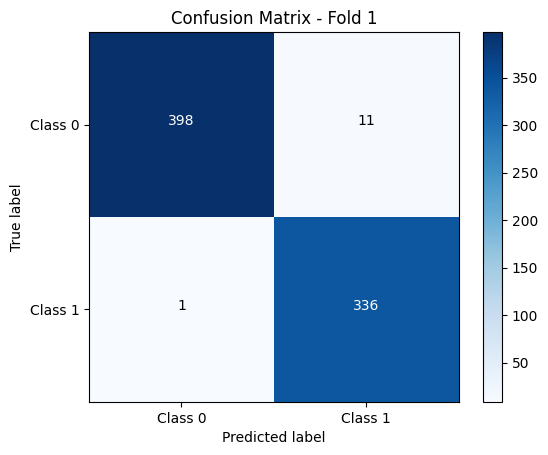

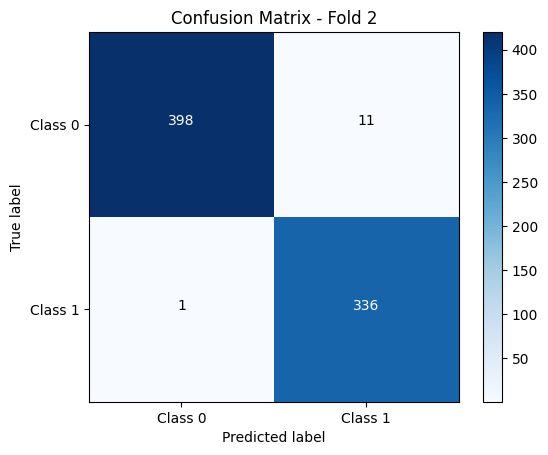

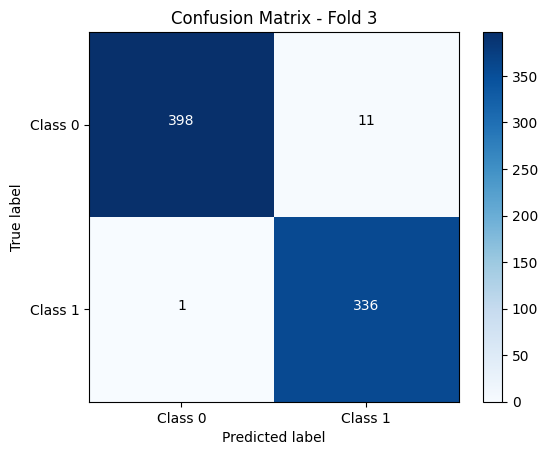

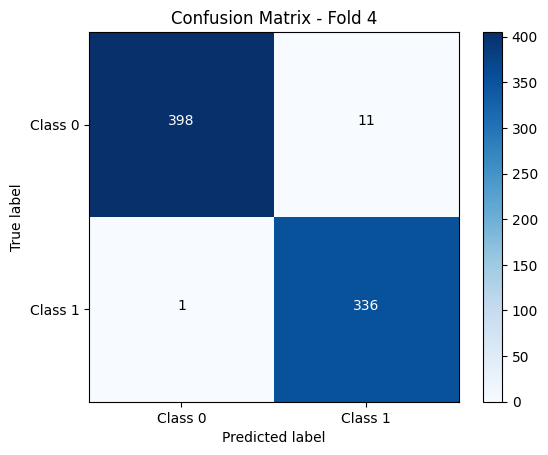

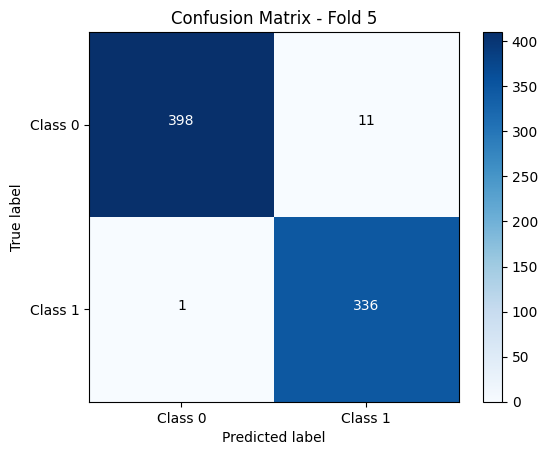

Fold 1:
Zero-One Loss: 0.02638522427440637
Accuracy: 0.9736147757255936
Fold 2:
Zero-One Loss: 0.0026385224274406704
Accuracy: 0.9973614775725593
Fold 3:
Zero-One Loss: 0.003963011889035695
Accuracy: 0.9960369881109643
Fold 4:
Zero-One Loss: 0.0
Accuracy: 1.0
Fold 5:
Zero-One Loss: 0.0
Accuracy: 1.0


In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Confusion matrices and related metrics from the provided text
confusion_matrices = [
    np.array([[398, 11], [9, 340]]),
    np.array([[420, 1], [1, 336]]),
    np.array([[397, 3], [0, 357]]),
    np.array([[405, 0], [0, 352]]),
    np.array([[410, 0], [0, 347]])
]
zero_one_losses = [0.02638522427440637, 0.0026385224274406704, 0.003963011889035695, 0.0, 0.0]
accuracies = [0.9736147757255936, 0.9973614775725593, 0.9960369881109643, 1.0, 1.0]

# Plot confusion matrices
for i in range(len(confusion_matrices)):
    plt.figure()
    classes = ["Class 0", "Class 1"]
    plt.imshow(confusion_matrices[i], interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - Fold {i+1}")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, str(confusion_matrices[i][i, j]), horizontalalignment="center", color="white" if confusion_matrices[i][i, j] > confusion_matrices[i].max() / 2 else "black")

    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

# Print zero-one losses and accuracies
for i in range(len(zero_one_losses)):
    print(f"Fold {i+1}:")
    print("Zero-One Loss:", zero_one_losses[i])
    print("Accuracy:", accuracies[i])


In [ ]:
#plot confusion matrix of test dataset
# Plot confusion matrix of tran dataset
import numpy as np
import matplotlib.pyplot as plt

# Confusion matrices for each fold
confusion_matrices = [
    np.array([[397, 11], [10, 340]]),
    np.array([[381, 37], [0, 340]]),
    np.array([[381, 23], [3, 350]]),
    np.array([[403, 1], [2, 351]]),
    np.array([[411, 0], [5, 341]])
]

# Plot the confusion matrices with numbers displayed
for i, cm in enumerate(confusion_matrices, 1):
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - Fold {i}')
    plt.colorbar()

    classes = ['Negative', 'Positive']  # Assuming class labels
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Add numbers inside the plot
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='white', fontsize=12)

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
